In [ ]:
#pick random frame in 12 hour window of livestream
import random

hour = random.randint(0, 11)
minute = random.randint(0, 59)
second = random.randint(0, 59)

print(f"Random time: {hour:02d}:{minute:02d}:{second:02d}")


Random time: 07:38:09


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#define train/val/test splits from provided deepfish csv files
import pandas as pd

df_train = pd.read_csv('/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/test.csv')

df_train.head()

,ID,habitats,labels,classes,frames
0,valid/7623_F2_f000460,7623,1,valid,7623_F2_f000460
1,empty/7585_NF2_f000230,7585,0,empty,7585_NF2_f000230
2,empty/7434_NF3_f000160,7434,0,empty,7434_NF3_f000160
3,empty/7585_NF2_f000160,7585,0,empty,7585_NF2_f000160
4,valid/9866_acanthopagrus_palmaris_f000030,9866,1,valid,9866_acanthopagrus_palmaris_f000030


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

def extract_polygons_and_cutout(mask_dir, image_dir, output_dir):
    # check if exists, then make into list
    os.makedirs(output_dir, exist_ok=True)
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

    for mask_file in mask_files:
        mask_path = os.path.join(mask_dir, mask_file)
        image_name = mask_file.replace('.png', '.jpg')
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Image file not found for mask: {mask_file}")
            continue

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)


        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # create empty mask
        output_mask = np.zeros_like(mask, dtype=np.uint8)

        # drawing countours
        cv2.drawContours(output_mask, contours, -1, color=255, thickness=-1)
        alpha_channel = np.zeros(mask.shape, dtype=np.uint8)
        alpha_channel[output_mask == 255] = 255

        transparent_cutout = np.dstack((image_rgb[:, :, :3], alpha_channel))

        output_path = os.path.join(output_dir, mask_file.replace('.png', '_cutout.png'))
        cv2.imwrite(output_path, transparent_cutout)
        print(f"Saved cutout to: {output_path}")

mask_dir = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/masks/valid'
#image_dir1 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/images/train'
image_dir2 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/images/val'

output_dir = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images'

#extract_polygons_and_cutout(mask_dir, image_dir1, output_dir)
extract_polygons_and_cutout(mask_dir, image_dir2, output_dir)


Saved cutout to: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/7398_F6_f000110_cutout.png
Saved cutout to: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/7398_F1_f000160_cutout.png
Image file not found for mask: 7398_F6_f000060.png
Saved cutout to: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/7117_Lutjanus_a_testclip_far_away_short_f000100_cutout.png
Image file not found for mask: 7117_Chaetodon_vagabundus_3_f000020.png
Image file not found for mask: 7117_Lutjanus_argentimaculatus_adult_2_f000080.png
Image file not found for mask: 7117_Lutjanus_argentimaculatus_adult_2_f000000.png
Image file not found for mask: 7398_F2_f000010.png
Saved cutout to: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_i

Source: GPT-4 for preprocessing that involves moving mass amounts of images/ to different folders

In [ ]:
#put validation segments away into a file based on csv
import os
import shutil

def move_cutout_files(df_val, column_name, source_folder, target_folder):
    """
    Moves files listed in a DataFrame column from the source folder to the target folder.

    Args:
        df_val (pd.DataFrame): The DataFrame containing file names.
        column_name (str): The column name containing the file names.
        source_folder (str): The folder where files currently exist.
        target_folder (str): The folder to move files to.
    """
    # Ensure target folder exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Iterate over each file name in the specified column
    for file_name in df_val[column_name]:
        # Append "_cutout" to the file name (before the file extension)
        name, ext = os.path.splitext(file_name)
        cutout_name = f"{name}_cutout.png"

        # Build full file paths
        source_path = os.path.join(source_folder, cutout_name)
        target_path = os.path.join(target_folder, cutout_name)

        # Check if the file exists in the source folder
        if os.path.exists(source_path):
            # Move the file
            shutil.move(source_path, target_path)
            print(f"Moved: {source_path} -> {target_path}")
        else:
            print(f"File not found: {source_path}")

# Define folders
source_folder = "/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images"  # Replace with the folder containing the files
target_folder = "/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/val"  # Replace with the folder to move the files to

# Move the files
move_cutout_files(df_val, column_name="frames", source_folder=source_folder, target_folder=target_folder)


File not found: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/9866_no_fish_f000100_cutout.png
File not found: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/9870_no_fish_f000130_cutout.png
File not found: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/9870_no_fish_f000140_cutout.png
File not found: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/9907_no_fish_2_f000000_cutout.png
Moved: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/9898_Acanthopagrus_palmaris_f000090_cutout.png -> /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images/val/9898_Acanthop

In [ ]:
#calculate the the mean and std for image size for gaussian size adjustment
import os
import numpy as np

def calculate_size_stats_from_yolo(folder_path):
    all_widths = []
    all_heights = []

    # Iterate through all .txt files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):  # Ensure we only process YOLO txt files
            file_path = os.path.join(folder_path, file_name)

            # Open and read the annotation file
            with open(file_path, 'r') as file:
                for line in file:
                    # YOLO format: class_id center_x center_y width height
                    parts = line.strip().split()
                    if len(parts) == 5:  # Ensure the line has the expected format
                        _, _, _, width, height = map(float, parts)  # Extract width and height
                        all_widths.append(width)
                        all_heights.append(height)

    # Convert to numpy arrays for mean and std calculation
    all_widths = np.array(all_widths)
    all_heights = np.array(all_heights)

    # Calculate mean and std for widths and heights
    mean_width = np.mean(all_widths) if len(all_widths) > 0 else 0
    std_width = np.std(all_widths) if len(all_widths) > 0 else 0
    mean_height = np.mean(all_heights) if len(all_heights) > 0 else 0
    std_height = np.std(all_heights) if len(all_heights) > 0 else 0

    print(f"Mean Width: {mean_width:.6f}, Std Width: {std_width:.6f}")
    print(f"Mean Height: {mean_height:.6f}, Std Height: {std_height:.6f}")

    return mean_width, std_width, mean_height, std_height

# Example usage:
folder_path = "/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/labels/train"  # Replace with the path to your YOLO txt files
mean_width, std_width, mean_height, std_height = calculate_size_stats_from_yolo(folder_path)

mean_area = mean_width * mean_height
std_area = std_width * std_height

print(f"Mean Area: {mean_area:.6f}, Std Area: {std_area:.6f}")


Mean Width: 0.197280, Std Width: 0.122247
Mean Height: 0.223976, Std Height: 0.130620
Mean Area: 0.044186, Std Area: 0.015968


In [ ]:
import os
import random
import shutil
import cv2
import numpy as np

def gaussian_size_adjustment(base_size, sigma):
    sampled_size = np.random.normal(base_size, sigma)
    return sampled_size

def simulated_annealing_object_placement(base_image, cutout_image, center_x, center_y, temperature, dw=100, dh=100):
    best_x, best_y = center_x, center_y
    best_score = float('inf')

    for _ in range(100):
        offset_x = int(np.random.uniform(-dw, dw) * temperature)
        offset_y = int(np.random.uniform(-dh, dh) * temperature)

        paste_x = max(0, min(base_image.shape[1] - cutout_image.shape[1], center_x + offset_x))
        paste_y = max(0, min(base_image.shape[0] - cutout_image.shape[0], center_y + offset_y))

        score = np.random.random()
        if score < best_score or np.random.rand() < np.exp((best_score - score) / temperature):
            best_score = score
            best_x, best_y = paste_x, paste_y

        temperature *= 0.95
    return best_x, best_y

#adjusted copy paste algorithm with sim anneal
def copy_paste_augmentation(base_images_folder, cutouts_folder, cutouts_txt_folder,
                            base_txt_folder, output_images_folder, output_txt_folder,
                            num_iterations=10, max_objects_per_image=30, temperature=1.0, decay_rate=0.95):

    os.makedirs(output_images_folder, exist_ok=True)
    os.makedirs(output_txt_folder, exist_ok=True)
    base_images = [f for f in os.listdir(base_images_folder) if f.endswith(('.jpg', '.png'))]
    cutout_images = [f for f in os.listdir(cutouts_folder) if f.endswith('.png')]

    for i in range(num_iterations):
        base_image_name = random.choice(base_images)
        base_image_path = os.path.join(base_images_folder, base_image_name)
        base_txt_path = os.path.join(base_txt_folder, base_image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

        base_image = cv2.imread(base_image_path, cv2.IMREAD_UNCHANGED)
        height, width = base_image.shape[:2]
        augmented_image = base_image.copy()
        new_bboxes = []

        num_centers = np.random.poisson(lam=3)
        centers = [(random.randint(0, width), random.randint(0, height)) for _ in range(num_centers)]

        for center_x, center_y in centers:
            num_objects = random.randint(1, max_objects_per_image // num_centers)
            first_object_size = None

            for _ in range(num_objects):
                cutout_name = random.choice(cutout_images)
                cutout_image_path = os.path.join(cutouts_folder, cutout_name)
                cutout_txt_name = cutout_name.replace('_cutout', '').replace('.png', '.txt')
                cutout_txt_path = os.path.join(cutouts_txt_folder, cutout_txt_name)

                if not os.path.exists(cutout_txt_path):
                    print(f"Warning: Annotation file missing for {cutout_name}")
                    continue

                cutout_image = cv2.imread(cutout_image_path, cv2.IMREAD_UNCHANGED)
                cutout_height, cutout_width = cutout_image.shape[:2]

                if first_object_size is None:
                    first_object_size = max(cutout_width, cutout_height)
                sampled_size = gaussian_size_adjustment(first_object_size, sigma=30)

                scale_factor = sampled_size / first_object_size
                resized_cutout = cv2.resize(cutout_image, (int(cutout_width * scale_factor), int(cutout_height * scale_factor)))

                paste_x, paste_y = simulated_annealing_object_placement(
                    base_image, resized_cutout, center_x, center_y, temperature, dw=100, dh=100
                )
                #adjusting model for images going ouside of range
                if resized_cutout.shape[2] == 4:
                    alpha_channel = resized_cutout[:, :, 3] / 255.0
                    cut_h, cut_w = resized_cutout.shape[:2]
                    max_y, max_x = augmented_image.shape[:2]

                    valid_h = min(cut_h, max_y - paste_y)
                    valid_w = min(cut_w, max_x - paste_x)

                    if valid_h > 0 and valid_w > 0:

                        resized_cutout_valid = resized_cutout[:valid_h, :valid_w]
                        alpha_channel = resized_cutout_valid[:, :, 3] / 255.0
                        alpha_channel = np.expand_dims(alpha_channel, axis=-1)
                        # blending into the backround
                        for c in range(3):
                            augmented_image[paste_y:paste_y+valid_h, paste_x:paste_x+valid_w, c] = (
                                augmented_image[paste_y:paste_y+valid_h, paste_x:paste_x+valid_w, c] * (1 - alpha_channel.squeeze()) +
                                resized_cutout_valid[:, :, c] * alpha_channel.squeeze()
                            )

                else:
                    augmented_image[paste_y:paste_y+resized_cutout.shape[0], paste_x:paste_x+resized_cutout.shape[1]] = resized_cutout

                with open(cutout_txt_path, 'r') as f:
                    for line in f:
                        class_id, x, y, w, h = map(float, line.strip().split())
                        new_x = (paste_x + x * resized_cutout.shape[1]) / width
                        new_y = (paste_y + y * resized_cutout.shape[0]) / height
                        new_w = w * resized_cutout.shape[1] / width
                        new_h = h * resized_cutout.shape[0] / height
                        new_bboxes.append(f"{int(class_id)} {new_x:.6f} {new_y:.6f} {new_w:.6f} {new_h:.6f}")

            temperature *= decay_rate

        output_image_name = f"aug_{i:04d}.jpg"
        output_image_path = os.path.join(output_images_folder, output_image_name)
        cv2.imwrite(output_image_path, augmented_image)

        output_txt_path = os.path.join(output_txt_folder, output_image_name.replace('.jpg', '.txt'))
        with open(output_txt_path, 'w') as f:
            if os.path.exists(base_txt_path):
                with open(base_txt_path, 'r') as base_f:
                    f.writelines(base_f.readlines())
            for bbox in new_bboxes:
                f.write(f"{bbox}\n")

        print(f"Generated: {output_image_path} and {output_txt_path}")


In [ ]:
base_images_folder = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/images/train'
cutouts_folder = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/cutout_images'
cutouts_txt_folder = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/labels/train'
base_txt_folder = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/labels/train'
output_images_folder = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/test'
output_txt_folder = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/test'
copy_paste_augmentation(base_images_folder, cutouts_folder, cutouts_txt_folder,
                            base_txt_folder, output_images_folder, output_txt_folder,
                            num_iterations=500, max_objects_per_image=30, temperature=1.0, decay_rate=0.95)

Generated: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/test/aug_0000.jpg and /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/test/aug_0000.txt
Generated: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/test/aug_0001.jpg and /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/test/aug_0001.txt
Generated: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/test/aug_0002.jpg and /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/test/aug_0002.txt
Generated: /c

Source GPT-4 for file management

In [ ]:
import os
import shutil

def copy_folder_contents(source_folder, destination_folder):
    """
    Copies all files and subdirectories from source_folder to destination_folder.

    Args:
        source_folder (str): Path to the source folder.
        destination_folder (str): Path to the destination folder.
    """
    # Ensure source folder exists
    if not os.path.exists(source_folder):
        raise FileNotFoundError(f"Source folder '{source_folder}' does not exist.")

    # Create destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Iterate through all items in the source folder
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)

        # Check if it's a file or folder and copy accordingly
        if os.path.isdir(source_item):
            # Recursively copy subdirectories
            shutil.copytree(source_item, destination_item, dirs_exist_ok=True)
        else:
            # Copy files
            shutil.copy2(source_item, destination_item)

    print(f"All contents from '{source_folder}' have been copied to '{destination_folder}'.")

source_folder1 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/images/train'
source_folder2 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/images/val'
source_folder3 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/labels/train'
source_folder4 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/labels/val'

destination_folder1 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/train'
destination_folder2 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/val'
destination_folder3 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/train'
destination_folder4 = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/val'

In [ ]:
copy_folder_contents(source_folder1, destination_folder1)
copy_folder_contents(source_folder2, destination_folder2)
copy_folder_contents(source_folder3, destination_folder3)
copy_folder_contents(source_folder4, destination_folder4)

All contents from '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/images/train' have been copied to '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/train'.
All contents from '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/images/val' have been copied to '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/val'.
All contents from '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_model/labels/train' have been copied to '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/train'.
All contents from '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Se

In [ ]:
#create yaml file for yolo detection
updated_dataset_yaml = """
train: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/train
val: /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/val
names:
  0: fish
"""

with open('/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_data_detect_tuned.yaml', 'w') as f:
    f.write(updated_dataset_yaml)


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install ultralytics

Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 20.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO('yolov10n.pt')

#train model
results = model.train(
    data='/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_data_detect_tuned.yaml',
    epochs=50,
    imgsz=640,
    task='detect',
    save=True,
    project='/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation',
    name='fish_detection_overnight'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.59M/5.59M [00:00<00:00, 272MB/s]


Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_data_detect_tuned.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation, name=fish_detection_overnight, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agno

100%|██████████| 755k/755k [00:00<00:00, 62.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

train: Scanning /content/drive/.shortcut-targets-by-id/131mw57xOAJq3SOyEZGO_dkt_JLPRmc9x/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/train.cache... 810 images, 179 backgrounds, 23 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/131mw57xOAJq3SOyEZGO_dkt_JLPRmc9x/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/train/aug_0019.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/131mw57xOAJq3SOyEZGO_dkt_JLPRmc9x/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/train/aug_0022.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0042]
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/131mw57xOAJq3SOyEZGO_dkt_JLPRmc9x/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/images/train/aug_0038.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0114]
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/131mw57xOAJq3SOyEZGO_dkt_JLPRmc9x/cs2831 final project/Trai

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/.shortcut-targets-by-id/131mw57xOAJq3SOyEZGO_dkt_JLPRmc9x/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/val.cache... 124 images, 59 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_detection_overnight/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_detection_overnight
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.791      4.258      2.797        101        640: 100%|██████████| 50/50 [14:53<00:00, 17.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:34<00:00, 23.74s/it]

                   all        124         82      0.155      0.256      0.149      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.672      3.057      2.704         90        640: 100%|██████████| 50/50 [14:02<00:00, 16.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.49s/it]

                   all        124         82      0.483      0.293      0.302      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G       2.68      2.745      2.677         73        640: 100%|██████████| 50/50 [14:11<00:00, 17.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.54s/it]

                   all        124         82      0.436      0.451       0.44       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.567      2.519      2.635         70        640: 100%|██████████| 50/50 [14:34<00:00, 17.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.28s/it]

                   all        124         82      0.564      0.551      0.542      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.482      2.365      2.597         56        640: 100%|██████████| 50/50 [14:04<00:00, 16.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.53s/it]

                   all        124         82      0.795      0.476       0.57      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.441      2.263      2.574         54        640: 100%|██████████| 50/50 [14:05<00:00, 16.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.50s/it]

                   all        124         82      0.554      0.476      0.518      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.378       2.11      2.528         84        640: 100%|██████████| 50/50 [14:00<00:00, 16.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.31s/it]

                   all        124         82      0.805      0.732      0.807      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.338      2.059      2.506         45        640: 100%|██████████| 50/50 [14:08<00:00, 16.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.44s/it]

                   all        124         82      0.804      0.599      0.685      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.277      2.007       2.46         11        640: 100%|██████████| 50/50 [14:14<00:00, 17.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.14s/it]

                   all        124         82      0.789      0.592      0.646      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.218       1.87      2.425         48        640: 100%|██████████| 50/50 [14:08<00:00, 16.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.13s/it]

                   all        124         82      0.664       0.65      0.639      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.193      1.796      2.422         78        640: 100%|██████████| 50/50 [14:27<00:00, 17.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.40s/it]

                   all        124         82      0.777      0.732      0.778      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.138       1.77      2.415         55        640: 100%|██████████| 50/50 [14:06<00:00, 16.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.52s/it]

                   all        124         82      0.917       0.72      0.847      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.106      1.722      2.394         70        640: 100%|██████████| 50/50 [14:16<00:00, 17.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.36s/it]

                   all        124         82      0.919      0.634      0.744       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.092      1.708      2.388         49        640: 100%|██████████| 50/50 [14:12<00:00, 17.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.54s/it]

                   all        124         82      0.775      0.672      0.766      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.056      1.666       2.36         82        640: 100%|██████████| 50/50 [14:14<00:00, 17.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.60s/it]

                   all        124         82       0.86      0.695      0.762      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.021      1.629      2.342         73        640: 100%|██████████| 50/50 [14:08<00:00, 16.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.51s/it]

                   all        124         82      0.932      0.549      0.606      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.019      1.605      2.356         64        640: 100%|██████████| 50/50 [14:36<00:00, 17.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.59s/it]

                   all        124         82      0.786      0.829      0.861      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.975      1.562      2.314         36        640: 100%|██████████| 50/50 [14:19<00:00, 17.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.55s/it]

                   all        124         82      0.915      0.658       0.78      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.964      1.545       2.32         44        640: 100%|██████████| 50/50 [14:14<00:00, 17.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.48s/it]

                   all        124         82      0.951      0.768      0.846       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.916      1.503      2.305         71        640: 100%|██████████| 50/50 [14:13<00:00, 17.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.30s/it]

                   all        124         82      0.876       0.86      0.888      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.941      1.496      2.291         83        640: 100%|██████████| 50/50 [14:11<00:00, 17.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.47s/it]

                   all        124         82      0.884      0.745      0.814      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.864      1.458       2.27         45        640: 100%|██████████| 50/50 [13:56<00:00, 16.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.58s/it]

                   all        124         82      0.986       0.85      0.912      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.855      1.441      2.269         43        640: 100%|██████████| 50/50 [13:58<00:00, 16.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.31s/it]

                   all        124         82      0.964      0.817      0.897      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.868      1.427       2.25        105        640: 100%|██████████| 50/50 [14:04<00:00, 16.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.23s/it]

                   all        124         82      0.973      0.866      0.918      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.787       1.37      2.225         97        640: 100%|██████████| 50/50 [14:05<00:00, 16.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.26s/it]

                   all        124         82      0.955      0.777      0.859      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.795      1.381      2.216        115        640: 100%|██████████| 50/50 [14:05<00:00, 16.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.18s/it]

                   all        124         82       0.98      0.756      0.887      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.746      1.349      2.218         33        640: 100%|██████████| 50/50 [13:58<00:00, 16.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.43s/it]

                   all        124         82      0.942      0.792      0.892      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.775      1.357      2.223         42        640: 100%|██████████| 50/50 [14:08<00:00, 16.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.54s/it]

                   all        124         82      0.986      0.848      0.904      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.749      1.327      2.189        369        640:  72%|███████▏  | 36/50 [10:29<04:08, 17.74s/it]

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_detection_overnight/weights/best.pt')

test_image_folder = '/content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images'


results = model.predict(
    source=test_image_folder,
    imgsz=640,
    conf=0.25,
    save=True,
    project='/content/drive/MyDrive/cs2831 final project/Test Results',
    name='test_run_bestmodel'
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-22-48-PM_png.rf.60fdc565edb292fe71006b87f9ea1038.jpg: 352x640 1 fish, 353.4ms
image 2/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-25-56-PM_png.rf.139af0812036df8c972cd14524fe5f6b.jpg: 352x640 2 fishs, 182.1ms
image 3/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-26-57-PM_png.rf.a812e294fece5a94708d91c2cca495f1.jpg: 352x640 3 fishs, 226.1ms
image 4/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Scr

In [ ]:

model = YOLO('/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_detection_run_base/weights/best.pt')
test_image_folder = '/content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images'

# output
output_project = '/content/drive/MyDrive/cs2831 final project/Test Results'
output_name = 'base_final_test'
output_dir = os.path.join(output_project, output_name)
os.makedirs(output_dir, exist_ok=True)


results = model.predict(
    source=test_image_folder,
    imgsz=640,
    conf=0.25,
    save=True,
    project=output_project,
    name=output_name
)


csv_file_path = os.path.join(output_dir, 'detection_summary.csv')

with open(csv_file_path, mode='w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Image', 'Number of Fish Detected'])

    for i, result in enumerate(results):
        image_path = result.path
        image_name = os.path.basename(image_path)
        txt_file_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.txt")

        # bounding boxes to .txt in YOLO format
        with open(txt_file_path, mode='w') as txtfile:
            for box in result.boxes.xywhn:
                class_id = int(box[-1])
                bbox = box[:4].tolist()
                txtfile.write(f"{class_id} {' '.join(map(str, bbox))}\n")

        # count fish
        num_fish_detected = len(result.boxes)
        csvwriter.writerow([image_name, num_fish_detected])

print(f"Results saved to {output_dir}")
print(f"Summary CSV file saved at {csv_file_path}")



image 1/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-22-48-PM_png.rf.60fdc565edb292fe71006b87f9ea1038.jpg: 352x640 1 fish, 189.9ms
image 2/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-25-56-PM_png.rf.139af0812036df8c972cd14524fe5f6b.jpg: 352x640 2 fishs, 163.5ms
image 3/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-26-57-PM_png.rf.a812e294fece5a94708d91c2cca495f1.jpg: 352x640 (no detections), 155.2ms
image 4/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-27-09-PM_png.rf.0d2369778879867145916654aff94ba5.jpg: 352x640 2 fishs, 162.3ms
image 5/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-27-25-PM_png.rf.7c3da088881b0c77b367d8814f7dac10.jpg: 352x640 (no detections), 16

In [ ]:
from ultralytics import YOLO
model = YOLO('/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_detection_run_base/weights/best.pt')

test_image_folder = '/content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images'


results = model.predict(
    source=test_image_folder,
    imgsz=640,
    conf=0.25,
    save=True,
    project='/content/drive/MyDrive/cs2831 final project/Test Results',
    name='test_run_basemodel'



image 1/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-22-48-PM_png.rf.60fdc565edb292fe71006b87f9ea1038.jpg: 352x640 1 fish, 169.5ms
image 2/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-25-56-PM_png.rf.139af0812036df8c972cd14524fe5f6b.jpg: 352x640 2 fishs, 178.6ms
image 3/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-26-57-PM_png.rf.a812e294fece5a94708d91c2cca495f1.jpg: 352x640 (no detections), 193.1ms
image 4/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-27-09-PM_png.rf.0d2369778879867145916654aff94ba5.jpg: 352x640 2 fishs, 162.9ms
image 5/52 /content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/images/Screenshot-2024-12-16-at-1-27-25-PM_png.rf.7c3da088881b0c77b367d8814f7dac10.jpg: 352x640 (no detections), 15

In [ ]:
# validate on test
metrics = model.val(
    data='/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_data_detect_tuned.yaml',  # Path to YAML file
    batch=16,
    task='detect',
    save_json=True,
    project='/content/drive/MyDrive/cs2831 final project/Test Results',
    name='evaluation_run1'
)
print(metrics)


Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/drive/.shortcut-targets-by-id/131mw57xOAJq3SOyEZGO_dkt_JLPRmc9x/cs2831 final project/Training data (preprocessing)/Segmentation/Data_for_tuned_model/training_for_yolo_tuned/labels/val.cache... 124 images, 59 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]


                   all        124         82      0.157      0.256      0.149     0.0884
Speed: 1.7ms preprocess, 200.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Saving /content/drive/MyDrive/cs2831 final project/Test Results/evaluation_run1/predictions.json...
Results saved to /content/drive/MyDrive/cs2831 final project/Test Results/evaluation_run1
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e10df7d10c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,   

Source GPT4 for plot generation since the model stopped training early it didnt automatically appear

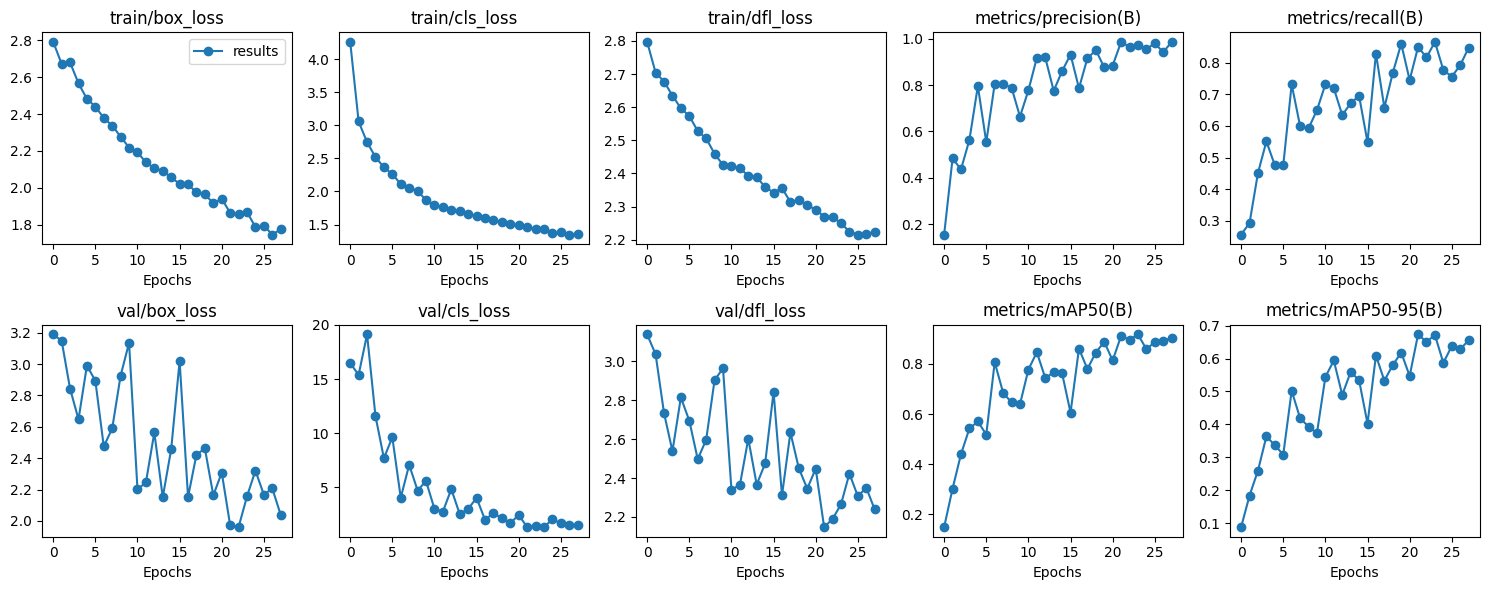

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = '/content/drive/MyDrive/cs2831 final project/Training data (preprocessing)/Segmentation/fish_detection_overnight/results.csv'  # Replace with the path to your CSV file
df = pd.read_csv(csv_path)

# Columns of interest
metrics = [
    'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)',
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
    'metrics/mAP50(B)', 'metrics/mAP50-95(B)'
]

# Initialize a 2x5 subplot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot each metric
for i, metric in enumerate(metrics):
    if metric in df.columns:  # Ensure the metric exists in the CSV
        axes[i].plot(df[metric], marker='o', linestyle='-', label='results', color='tab:blue')
        # Optional smoothing using rolling average
        axes[i].set_title(metric)
        axes[i].set_xlabel('Epochs')
    else:
        axes[i].set_title(f"{metric} (Not in CSV)")

# Add legend
axes[0].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


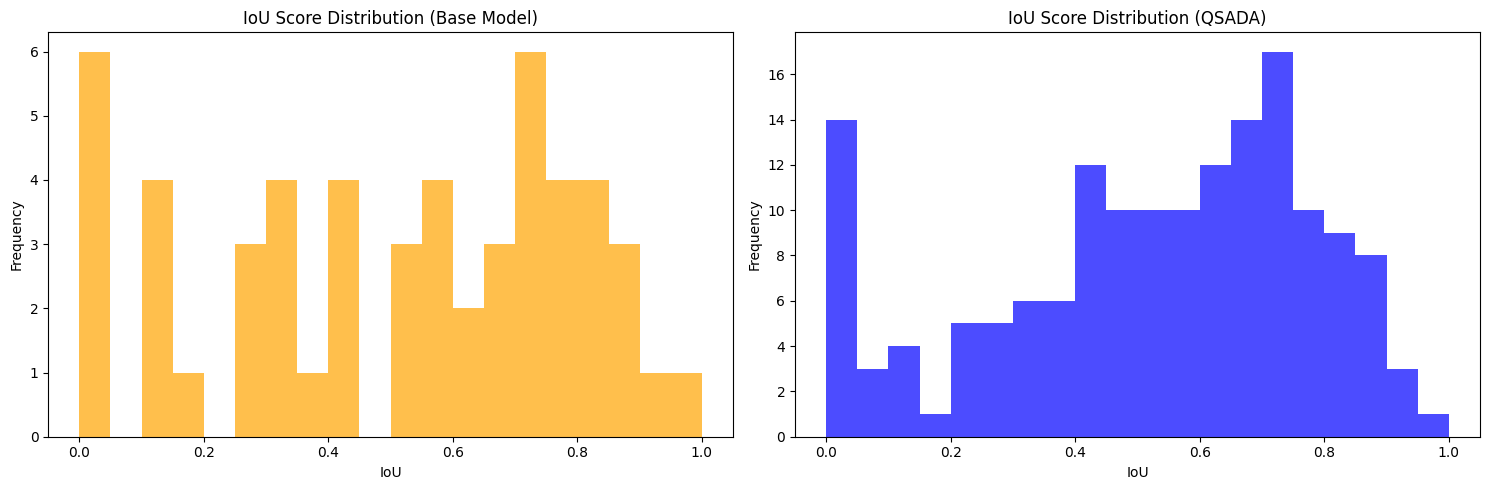

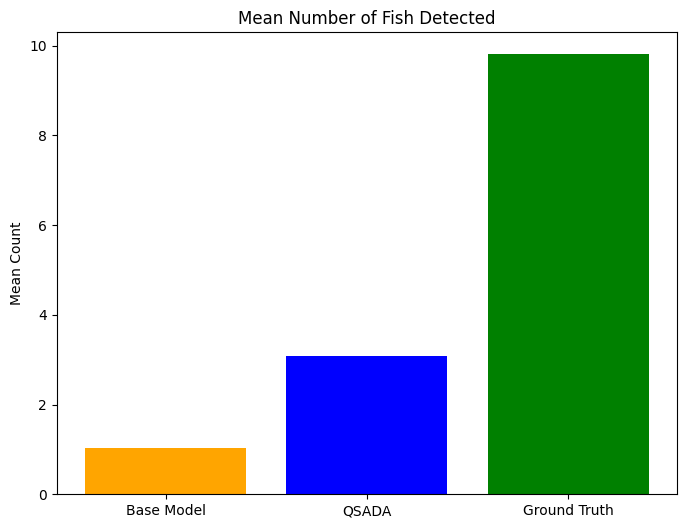

In [ ]:
def comparative_plot_results(iou_scores_model1, iou_scores_model2, count_comparison_model1, count_comparison_model2, model1_name, model2_name):
    #iou histogram
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.hist(iou_scores_model2, bins=20, range=(0, 1), color='orange', alpha=0.7)
    plt.title(f'IoU Score Distribution ({model2_name})')
    plt.xlabel('IoU')
    plt.ylabel('Frequency')

    # IoU model1
    plt.subplot(1, 2, 2)
    plt.hist(iou_scores_model1, bins=20, range=(0, 1), color='blue', alpha=0.7)
    plt.title(f'IoU Score Distribution ({model1_name})')
    plt.xlabel('IoU')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # mean comparison (both)
    filenames_model1 = list(count_comparison_model1.keys())
    filenames_model2 = list(count_comparison_model2.keys())
    model1_counts = [count_comparison_model1[f]["model_count"] for f in filenames_model1]
    model2_counts = [count_comparison_model2[f]["model_count"] for f in filenames_model2]
    gt_counts = [count_comparison_model1[f]["ground_truth_count"] for f in filenames_model1]

    mean_model1 = np.mean(model1_counts)
    mean_model2 = np.mean(model2_counts)
    mean_gt = np.mean(gt_counts)

    plt.figure(figsize=(8, 6))
    plt.bar([model2_name, model1_name, 'Ground Truth'], [mean_model2, mean_model1, mean_gt], color=['orange', 'blue', 'green'])
    plt.title('Mean Number of Fish Detected')
    plt.ylabel('Mean Count')
    plt.show()


# model eval
pred_folder_model1 = '/content/drive/MyDrive/cs2831 final project/Test Results/qsada_test'
pred_folder_model2 = '/content/drive/MyDrive/cs2831 final project/Test Results/base_final_test'
gt_folder = '/content/drive/MyDrive/cs2831 final project/Test Data (florida keys)/test/labels'

iou_scores_model1, count_comparison_model1 = evaluate_model(pred_folder_model1, gt_folder)
iou_scores_model2, count_comparison_model2 = evaluate_model(pred_folder_model2, gt_folder)

# plot results
comparative_plot_results(
    iou_scores_model1,
    iou_scores_model2,
    count_comparison_model1,
    count_comparison_model2,
    model1_name="QSADA",
    model2_name="Base Model"
)
